## Compute forecast metrics using item-level backtests

<b>DC Bikeshare Rentals data</b>

Our goal is to predict the number of DC Bikeshare rentals in the next 24 hours for each of 467 rental locations.  To do this, we used Amazon Forecast to create forecasts with 1 hour frequency and 1 week forecast horizon.   
<ul>
    <li>See <a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/">blog post for screens how the forecast was created.</a></li>
    <li>Original data source: <a href="https://www.capitalbikeshare.com/system-data"> https://www.capitalbikeshare.com/system-data</a> </li>
</ul>

This notebook picks up after the blog post Predictor has been trained.  In the overall Amazon Forecast workflow, <b>this notebook covers <i>the step "Inspect ML model" which comes between steps Train ML model and Host ML model</i>, see overview image below.</b>  For demo purposes, we will visualize the item-level accuracies and calculate a custom item-level MAPE error metric, since customers often ask for custom metrics separate from standard weighted quantile loss (wQL).
<br>

Amazon Forecast Notebooks are useful to see the overall Forecast API workflow, see for example:<br>
<li><a href="https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Incorporating_Related_Time_Series_dataset_to_your_Predictor/Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb", target="_blank">Creating Related Time Series notebook for a good overview of the non-Weather Forecast API steps.</a></li>

Once you've run through a notebook once or twice, you'll probably decide you don't want to call Forecast APIs anymore via notebook!  More efficient use of your time is to call APIs from automation.  When you're ready, take a look at our Solution that uses AWS Lambda Step Functions and Amazon Quicksight for visualization to integrate Amazon Forecast with upstream/downstream Data applications.
<ul>
    <li><a href="https://aws.amazon.com/solutions/implementations/improving-forecast-accuracy-with-machine-learning", target='_blank'>Amazon Forecast Automation Solution</a></li>
    </ul>



<img src="images/forecast_steps_overview.png" width="98%">

<br>


# Table of Contents for task "inspect ML model"
* Step 0: [Set up and install libraries](#setup)
* Step 1: [Export predictor backtests](#export)
* Step 2: [Assemble and read predictor backtest files](#read)
* Step 3: [Visualize backtest window accuracy](#visualize)
* Step 4: [Calculate custom MAPE](#mape)


# Step 0:  Set up  <a class="anchor" id="setup"></a>
Import and install Python and aws libraries


In [1]:
import sys
import os
import shutil

import pandas as pd
print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display all rows long
pd.set_option('display.max_rows', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
print('numpy: {}'.format(np.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 


# get region from boto3
import boto3
REGION = boto3.Session().region_name

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

pandas: 1.0.5
numpy: 1.19.1


In [2]:
#########
# Function to concat .part files in predictor backtest file export folder
#########

def read_backtest_predictions(BUCKET_NAME, s3_path):
    """Read predictor backtest predictions export files
       Inputs: 
           BUCKET_NAME = S3 bucket name
           s3_path = S3 path to Predictor.part files
                         , everything after "s3://BUCKET_NAME/" in S3 URI path to your .part files
       Return: Pandas dataframe with all .part files concatenated row-wise
    """
    # set s3 path
    s3 = boto3.resource('s3')
    s3_bucket = boto3.resource('s3').Bucket(BUCKET_NAME)
    s3_depth = s3_path.split("/")
    s3_depth = len(s3_depth) - 1
    
    # set local path
    local_write_path = "backtest_exports"
    if (os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        shutil.rmtree('backtest_exports')
    if not(os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        os.makedirs(local_write_path)
    
    # concat part files
    part_filename = ""
    part_files = list(s3_bucket.objects.filter(Prefix=s3_path))
    print(f"Number .part files found: {len(part_files)}")
    for file in part_files:
        # There will be a collection of CSVs if the forecast is large, modify this to go get them all
        if "csv" in file.key:
            part_filename = file.key.split('/')[s3_depth]
            window_object = s3.Object(BUCKET_NAME, file.key)
            file_size = window_object.content_length
            if file_size > 0:
                s3.Bucket(BUCKET_NAME).download_file(file.key, local_write_path+"/"+part_filename)
        
    # Read from local dir and combine all the part files
    temp_dfs = []
    for entry in os.listdir(local_write_path):
        if os.path.isfile(os.path.join(local_write_path, entry)):
            df = pd.read_csv(os.path.join(local_write_path, entry), index_col=None, header=0)
            temp_dfs.append(df)

    # Return assembled .part files as pandas Dataframe
    fcst_df = pd.concat(temp_dfs, axis=0, ignore_index=True, sort=False)
    return fcst_df


#########
# Functions to classify items as "top movers" or not
#########

def get_velocity_per_item(df, timestamp_col, item_id_col="item_id"):
    """Calculate item velocity as item demand per hour.  
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%Y-%m-%d %H:%M:%S')
    
    max_time_df = df.groupby([item_id_col], as_index=False).max()[[item_id_col, timestamp_col]]
    max_time_df.columns = [item_id_col, 'max_time']
    
    min_time_df = df.groupby([item_id_col], as_index=False).min()[[item_id_col, timestamp_col]]
    min_time_df.columns = [item_id_col, 'min_time']
    
    df = df.merge(right=max_time_df, on=item_id_col)
    df = df.merge(right=min_time_df, on=item_id_col)
    
    df['time_span'] = df['max_time'] - df['min_time']
    df['time_span'] = df['time_span'].apply(lambda x: x.seconds / 3600 + 1) # add 1 to include start datetime and end datetime
    df = df.groupby([item_id_col], as_index=False).agg({'time_span':'mean', 'target_value':'sum'})
    df['velocity'] = df['target_value'] / df['time_span']
    return df


def get_top_moving_items(gt_df
                                   , timestamp_col
                                   , target_value_col
                                   , item_id_col="item_id"):
    """Calculate mean velocity over all items as "criteria".
       Assign each item into category "top" or not depending on whether its velocity > criteria.
    """
    gt_df_velocity = gt_df[[item_id_col, timestamp_col, target_value_col]].copy().reset_index(drop=True)
    gt_df_velocity = get_velocity_per_item(gt_df_velocity, timestamp_col, item_id_col)
    criteria = gt_df_velocity['velocity'].mean()
    gt_df_velocity['top_moving'] = gt_df_velocity['velocity'] > criteria
    print('average velocity of all items:', criteria)
    
    top_moving_items = gt_df_velocity[gt_df_velocity['top_moving'] == True][item_id_col].to_list()
    slow_moving_items = gt_df_velocity[gt_df_velocity['top_moving'] == False][item_id_col].to_list()
    return top_moving_items, slow_moving_items


###########
# Functions to calculate metrics
###########

def truncate_negatives_to_zero(the_df, target_value_col, quantile_cols):
    """In case you are expecting positive numbers for actuals and predictions,
       round negative values up to zero.
       
       Be careful that this is acceptable treatment of negatives for your use case.
    """
    
    df = the_df.copy()
    
    for q in quantile_cols:
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

        # replace
        df[q] = df[q].mask(df[q] < 0, 0)

        # check you did the right thing
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

    # truncate negative actuals
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

    # replace
    df[target_value_col] = df[target_value_col].mask(df[target_value_col] < 0, 0)

    # check you did the right thing
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")
    
    return df

       
def calc_mape(target, forecast):
    """Calculates custom mape for a specific quantile and window with formula:
            sum(| |predicted| - |actual| | / |actual|)
       Input: single numbers for target and forecast
       Output: mape = floating point number
    """
    denominator = np.abs(target)
    flag = denominator <= 1e-8

    mape = np.mean(
        (np.abs( np.abs(target) - np.abs(forecast)) * (1.0 - flag)) / (denominator + flag)
    )
    return mape



In order to run Amazon Forecast, you'll need an AWS account.  
<b>Make sure you can log in to: https://console.aws.amazon.com/.  </b>  Then read each cell carefully and execute the cells in this notebook.
<br>

<b>Configure the S3 bucket name and region name for this lesson.</b>

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [ ]:
## Get user inputs for S3 bucket name and region

default_bucket = "bike-demo"  #default taxi-demo
bucket_name = input("S3 bucket name [enter to accept default]: ") or default_bucket
default_region = REGION
REGION = input(f"region [enter to accept default]: {default_region} ") or default_region 

The next part of the setup process is to validate that your account can communicate with Amazon Forecast

In [4]:
# Connect API session
session = boto3.Session(region_name=REGION) 
forecast = session.client(service_name='forecast') 
#forecast_query = session.client(service_name='forecastquery') #not used in this notebook


The last part of the setup process is to create an AWS Role with Forecast and S3 permissions

In [ ]:
# Create the role to provide to Amazon Forecast.

role_name = "ForecastNotebookRole"
print(f"Creating Role {role_name} ...")
role_arn = util.get_or_create_iam_role( role_name = role_name )


In [ ]:
# check you did the right thing
forecast.list_predictors()

# Step 1: Export predictor backtests <a class="anchor" id="export"></a>

After creating the predictors, we can export the Backtest Predictions to evaluate the performance of the algorithm, using custom item-level metrics if desired. "Backtesting" is a cross-validation technique for time series that uses multiple train/test splits that keep time order of the data. Using multiple train-test splits (i.e. more than 1 backtest window) will result in more models being trained, and in turn, a more robust estimate how the model (chosen algorithm and hyperameters) will perform on unseen data. 

<img src="images/backtest.png" width="80%" ></img>

<li><a href="https://docs.aws.amazon.com/forecast/latest/dg/metrics.html#backtesting", target='_blank'> More details about backtesting on the Amazon Forecast documentation page.</a></li>

In the next cell, we use your Predictor arn and export backtest files to your S3 bucket.  <b>To find your predictor ARN, navigate in the Amazon Forecast UI to your Predictor page. </b>
<img src="images/predictorARN.png" width="70%" ></img>
<br>

In [ ]:
## Get user inputs for predictor arn 

default_predictor_arn = "arn:aws:forecast:us-west-2:123456789012:predictor/bike_demo_auto"  
predictor_arn = input("predictor arn [enter to accept default]: ") \
                            or default_predictor_arn

In [ ]:
# Decide automatically where to save exported files

default_export_path = \
    f's3://{bucket_name}/backtest_exports/bike_demo_auto/'
print(f"exporting to: {default_export_path}")
export_path = default_export_path

<br>
In the next few cells, we ask Amazon Forecast to export the Predictor backtest window forecasts via API.  The same could be done by <li><a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/">clicking the "Export backtest results" button on the Predictor page, as shown in the blog.</a></li>
<br>
<br>

In [13]:

## Call CreatePredictorBacktestExportJob using predictor Arn and S3 export path

backtestExportJobName = 'bike_demo_forecasts'
backtest_export_job_response =forecast.create_predictor_backtest_export_job(PredictorBacktestExportJobName=backtestExportJobName,
                                                          PredictorArn=predictor_arn,
                                                          Destination= {
                                                              "S3Config" : {
                                                                 "Path":export_path,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          })

In [ ]:

# check for HTTPStatusCode 200
backtest_export_job_arn = backtest_export_job_response['PredictorBacktestExportJobArn']
backtest_export_job_response

In [15]:

## CHECK STATUS OF YOUR EXPORT JOB - BACKTEST FORECASTS


status = util.wait(lambda: forecast.describe_predictor_backtest_export_job(PredictorBacktestExportJobArn=
                backtest_export_job_arn))

# Wait until you see "ACTIVE" below...
# This will take a while, go get a cup of tea now. 

CREATE_PENDING .
CREATE_IN_PROGRESS ...........................................................
ACTIVE 


<br>
The API steps you did above, could equivalently be done in the UI by clicking the "Export backtest results" button on the Predictor page.  You'll see export job details on the screen.

<img src="images/export_backtest_results.png" width="80%" ></img>

# Step 2: Assemble and read predictor backtest files <a class="anchor" id="read"></a>

After Forecast Predictor Backtest Export step finishes, you will have a number of .part files within 2 separate folders.  The cell below concatenates all the .part files per folder into a single .csv file which can be saved to an S3 location of your choice. <br>

The folder structure for "Item-level standard accuracy metrics" and "Item-level forecasted values" folders will look like this on your S3 bucket:

<img src="images/export_backtest_folders.png" width="40%" ></img>
<br>

### Assemble and read Accuracy metrics file

In [16]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = export_path.split(bucket_name)[1][1:]
s3_path_to_files = s3_path_to_files + "accuracy-metrics-values/"
print(f"path to files: {s3_path_to_files}")

path to files: backtest_exports/bike_demo_auto/accuracy-metrics-values/


In [18]:

## READ THE ACCURACIES FILE

accuracy_df = read_backtest_predictions(bucket_name, s3_path_to_files)
# accuracy_df = pd.read_csv("data/bike_backtest_accuracies.csv")

# keep only data rows
print(accuracy_df.shape)
accuracy_df = accuracy_df.loc[(accuracy_df.backtestwindow_start_time != "backtestwindow_start_time"), :].copy()
print(accuracy_df.shape)
accuracy_df.drop_duplicates(inplace=True)
print(accuracy_df.shape)

# correct data types
accuracy_df.item_id = accuracy_df.item_id.astype(str)
accuracy_df['backtestwindow_start_time'] = pd.to_datetime(accuracy_df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
accuracy_df['backtestwindow_end_time'] = pd.to_datetime(accuracy_df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
accuracy_df['backtestwindow_start_time'] = accuracy_df.backtestwindow_start_time.dt.tz_localize(None)
accuracy_df['backtestwindow_end_time'] = accuracy_df.backtestwindow_end_time.dt.tz_localize(None)

# correct dtypes
for q in accuracy_df.iloc[:, -4:].columns:
    accuracy_df[q] = pd.to_numeric(accuracy_df[q], errors='coerce')

# check
num_items = len(accuracy_df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print("Backtest Window Start Dates")
print(accuracy_df.backtestwindow_start_time.unique())

print(accuracy_df.dtypes)
accuracy_df.sample(5)

(8406, 8)
(8406, 8)
(3384, 8)
Num items: 467
Backtest Window Start Dates
['2017-06-19T00:00:00.000000000' '2017-06-20T00:00:00.000000000'
 '2017-06-21T00:00:00.000000000' '2017-06-22T00:00:00.000000000'
 '2017-06-23T00:00:00.000000000']
item_id                              object
backtest_window                      object
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
wQL[0.65]                           float64
wQL[0.9]                            float64
RMSE                                float64
WAPE                                float64
dtype: object


,item_id,backtest_window,backtestwindow_start_time,backtestwindow_end_time,wQL[0.65],wQL[0.9],RMSE,WAPE
3829,32017,Computed,2017-06-22,2017-06-22 23:00:00,0.12748,0.07414,0.00628,0.14212
2289,31308,Summary,2017-06-19,2017-06-23 23:00:00,0.98018,0.78382,1.03534,15.14547
2184,31092,Summary,2017-06-19,2017-06-23 23:00:00,1.08593,1.47028,0.29939,2.25373
3731,31222,Computed,2017-06-19,2017-06-19 23:00:00,0.83430,0.63782,3.92395,61.33376
3356,31056,Computed,2017-06-23,2017-06-23 23:00:00,1.23448,1.60014,0.49670,5.97460


Typically, you would save the assembled accuracy file on your S3 bucket.  We've already saved it to data/bike_backtest_accuracies.csv.

### Assemble and read Forecasted values file

In [19]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = export_path.split(bucket_name)[1][1:]
s3_path_to_files = s3_path_to_files + "forecasted-values/"
print(f"path to files: {s3_path_to_files}")

path to files: backtest_exports/bike_demo_auto/forecasted-values/


In [21]:

## READ THE FORECASTS FILE

df = read_backtest_predictions(bucket_name, s3_path_to_files)
# df = pd.read_csv("data/bike_backtest_forecasts.csv")

# correct data types
df.item_id = df.item_id.astype(str)
df.target_value = pd.to_numeric(df.target_value, errors='coerce')
df.timestamp = pd.to_datetime(df.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_start_time'] = pd.to_datetime(df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_end_time'] = pd.to_datetime(df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
df.timestamp = df.timestamp.dt.tz_localize(None)

# drop duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

# check
num_items = len(df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print()
print("Backtest Window Start Dates")
print(df.backtestwindow_start_time.unique())

print(df.dtypes)
df.sample(5)

(167544, 8)
(55848, 8)
Num items: 467

Backtest Window Start Dates
['2017-06-19T00:00:00.000000000' '2017-06-20T00:00:00.000000000'
 '2017-06-21T00:00:00.000000000' '2017-06-22T00:00:00.000000000'
 '2017-06-23T00:00:00.000000000']
item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
mean                                float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90
4912,31501,2017-06-19 10:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,-0.00028,0.00001,0.00056
44633,31242,2017-06-22 23:00:00,0.00000,2017-06-22,2017-06-22 23:00:00,0.06621,0.07566,0.46273
25457,31407,2017-06-21 06:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,-0.00415,-0.00152,0.00439
22876,31622,2017-06-21 01:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,-0.00549,-0.00276,0.00439
40946,31032,2017-06-22 16:00:00,1.00000,2017-06-22,2017-06-22 23:00:00,0.00189,0.00255,0.00435


Typically, you would save the assembled accuracy file on your S3 bucket.  We've already saved it to data/bike_backtest_forecasts.csv.

## Demo using the item-level forecast files  

The rest of this notebook will focus on how to use the item-level forecasts from the Predictor backtest windows. 
<br>

#### Get quantile columns

In [22]:
# Map column names in your data to expected key words
item_id = "item_id"
target_value = "target_value"
timestamp = "timestamp"
location_id = "item_id"

In [23]:
# target = "target_value"
# set predictor dimensions from forecast df
predictor_cols = ['item_id', 'timestamp', 'rest_no', 'backtestwindow_start_time', 'backtestwindow_end_time']
# exclude cols to automatically find quantiles
exclude_cols = predictor_cols.copy()
exclude_cols.append(target_value)

# get quantile columns from forecast dataframe
quantile_cols = [c for c in df.columns if c not in exclude_cols] 
num_quantiles = len(quantile_cols)
print(f"num quantiles: {num_quantiles}")
quantile_cols

num quantiles: 3


['mean', 'p65', 'p90']

In [24]:
# correct data types
for q in quantile_cols:
    df[q] = pd.to_numeric(df[q], errors='coerce')

print(df.dtypes)
df.sample(5)

item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
mean                                float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90
53819,31234,2017-06-23 19:00:00,1.00000,2017-06-23,2017-06-23 23:00:00,3.64196,4.87485,7.29926
39646,31040,2017-06-22 13:00:00,1.00000,2017-06-22,2017-06-22 23:00:00,0.00302,0.00370,0.00879
11714,31246,2017-06-20 01:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.01343,0.01143,0.02614
40825,31916,2017-06-22 15:00:00,0.00000,2017-06-22,2017-06-22 23:00:00,0.52014,0.75401,1.95905
9521,31026,2017-06-19 20:00:00,1.00000,2017-06-19,2017-06-19 23:00:00,0.41480,0.40937,1.13862


#### Before calling error calcs, truncate negative actuals and predictions to 0
If you are not expecting negatives, such as for counts

In [25]:

### Before calling error calcs, truncate negative actuals and predictions to 0

df_eligible = df.copy()
df_eligible = truncate_negatives_to_zero(df_eligible
                                         , target_value_col=target_value
                                         , quantile_cols=quantile_cols)


Num negative mean predictors: 14166
Num negative mean predictors: 0
Num negative p65 predictors: 11382
Num negative p65 predictors: 0
Num negative p90 predictors: 367
Num negative p90 predictors: 0
Num negative actuals: 0
Num negative actuals: 0


In [26]:
# Add day of week for convenience
df_eligible['day_of_week'] = df_eligible.timestamp.dt.day_name()
print(df_eligible.day_of_week.value_counts())

# Add window number for convenience
windows = df_eligible.backtestwindow_start_time.value_counts().rename_axis('backtestwindow_start_time').reset_index(name='count')
windows.sort_values('backtestwindow_start_time', inplace=True)
windows.reset_index(inplace=True, drop=True)
windows.drop('count', axis=1, inplace=True)
windows['window'] = windows.index + 1

print(df_eligible.shape)
df_eligible = df_eligible.merge(windows, how="left", on="backtestwindow_start_time")
print(df_eligible.shape)
df_eligible.sample(5)

Friday       11208
Wednesday    11160
Monday       11160
Thursday     11160
Tuesday      11160
Name: day_of_week, dtype: int64
(55848, 9)
(55848, 10)


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90,day_of_week,window
43963,31231,2017-06-22 22:00:00,1.00000,2017-06-22,2017-06-22 23:00:00,1.28243,1.10890,4.31951,Thursday,4
24088,32222,2017-06-21 03:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00000,0.00029,Wednesday,3
6018,32005,2017-06-19 12:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.00000,0.00000,0.00170,Monday,1
40282,32008,2017-06-22 14:00:00,0.00000,2017-06-22,2017-06-22 23:00:00,0.00099,0.00257,0.00449,Thursday,4
54083,31002,2017-06-23 20:00:00,1.00000,2017-06-23,2017-06-23 23:00:00,1.65187,1.67308,4.75659,Friday,5


# Step 3: Visualize the Backtest Window forecasts  <a class="anchor" id="visualize"></a>

Below is 1 chart per item, for 5 random items in the "top-movers" item group.  Y-axis is Actuals and color-coded Forecasts at each quantile.  X-axis is time, starting from the first Backtest Window and ending with the last Backtest Window.
<br>

In [27]:
quantile_cols
plot_columns = [item_id, timestamp, target_value]
plot_columns = plot_columns + quantile_cols
plot_columns

['item_id', 'timestamp', 'target_value', 'mean', 'p65', 'p90']

In [28]:
# instead of random top-movers, choose some fixed examples
random_items = ["31519", "31505", "31519", "31639", "31623"]

# assemble no_weather and weather values
df_plot = df_eligible.loc[(df_eligible.item_id.isin(random_items)), plot_columns].copy()
# rename "target_value" to "actual_value" for clearer viz
df_plot.rename(columns={'target_value':'actual_value'}, inplace=True)
df_plot = df_plot.groupby([timestamp, item_id]).sum()
df_plot.reset_index(inplace=True)
df_plot.set_index(timestamp, inplace=True)
df_plot.head(2)

,item_id,actual_value,mean,p65,p90
timestamp,,,,,
2017-06-19,31505,0.00000,0.00000,0.00000,0.00542
2017-06-19,31519,1.00000,0.00000,0.00000,0.01000


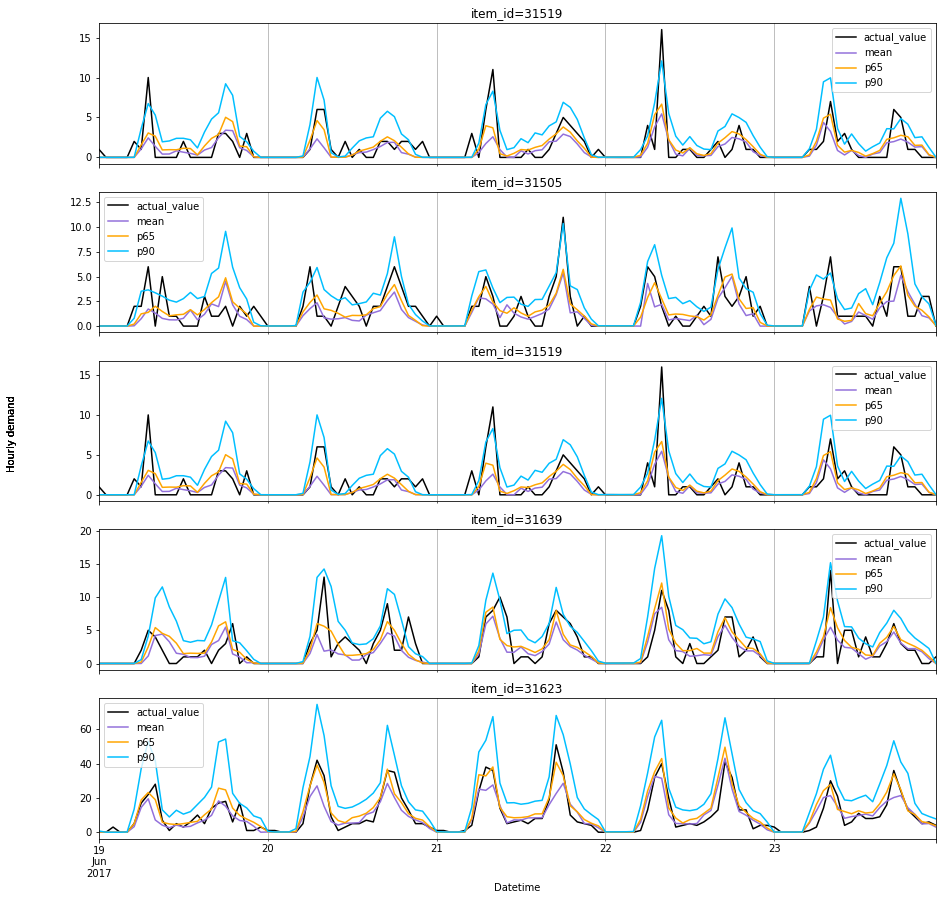

In [29]:
# Visualize items
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)

for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed = df_plot.loc[(df_plot[item_id]==item), :].copy()

    zoomed[['actual_value']].plot(ax=axs[i], color='k')
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
            
    axs[i].set_title(f"item_id={item}")  
    # set common Y label 
    fig.text(0.04, 0.5, 'Hourly demand', va='center', rotation='vertical')
    
    # format the x ticks
    axs[i].set_xlabel("Datetime")   
        
    # format the grid
    axs[i].grid(False)
    axs[i].grid(which='minor', axis='x')

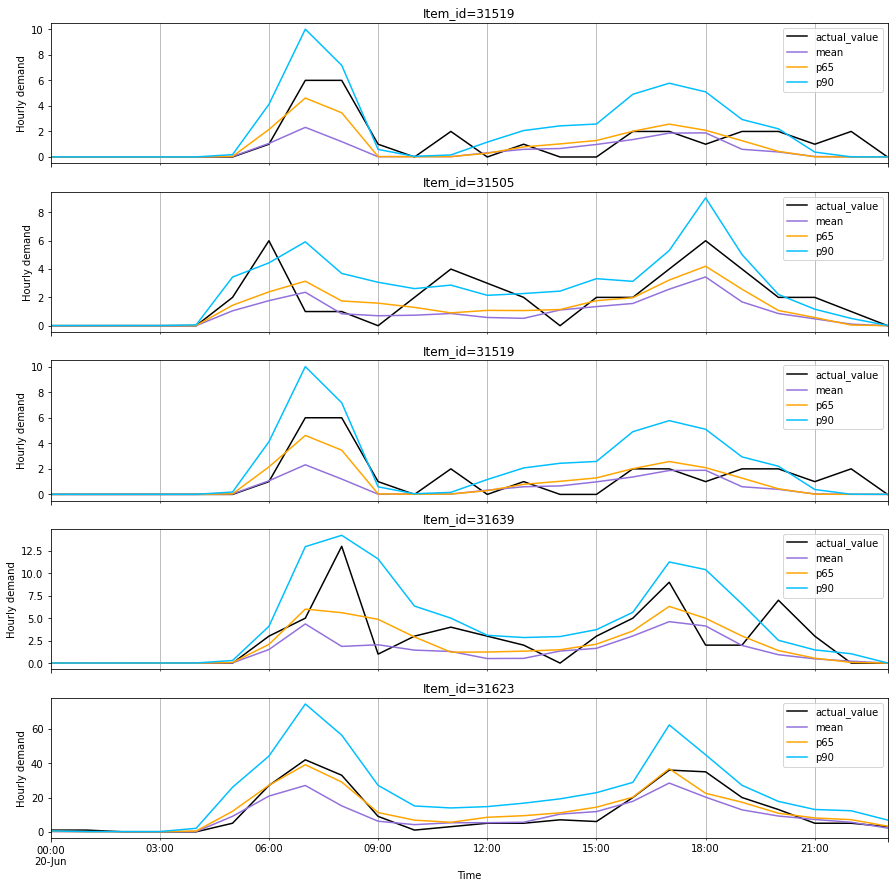

In [30]:
# Visualize items - zoom in to see hours
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed = df_plot.loc[(df_plot[item_id]==item), :].copy()
    zoomed = zoomed['2017-06-20':'2017-06-20']

    zoomed[['actual_value']].plot(ax=axs[i], color='k')    
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
            
    axs[i].set_title(f"Item_id={item}")
    axs[i].set_xlabel("Time")    #date
    axs[i].set_ylabel("Hourly demand")   
    axs[i].grid(which='minor', axis='x')


Above, peak hours for bicycle rental appear to be between 5-9am and 3-9pm.  For a real customer study, we really should select more data to verify the peak hours...
<br>

# Step 4:  Calculate custom MAPE item-level accuracy  <a class="anchor" id="mape"></a>

An example customer metric request might be - tell me MAPE for my top-moving items, during peak hours, and tell me this before deploying the Predictor.  Also, please use this MAPE formula.  MAPE = sum( |yhat - y| / |y| ).
<br>
<br>
To tackle this, we'll use the raw actuals, forecasts we just exported from the Predictor backtest windows.  Steps to calculate:
<ul>
    <li>First, we'll segment the items into "top-movers" category, depending on how much demand they have. </li>
    <li>Then we'll calculate a custom accuracy MAPE for each group of items.</li>  
    <li>Finally, we'll do some visualizations of item demand actuals and forecasts.</li>
    </ul>
    
The reason to focus on "top-movers" is typically item sales have negative binomial distribution - meaning about 20% of the items account for about 80% of sales.  Customers often want to do analysis around the top-selling items; otherwise they would see analysis around mostly items with 0 sales.

In [31]:
## CALCULATE DEMAND VOLUME OF ITEMS

# categorize items as "top movers" or not
top_moving_items, slow_moving_items = get_top_moving_items(df_eligible, timestamp, target_value, item_id)

# assign item velocity
df_eligible['velocity'] = "slow"
df_eligible.loc[(df_eligible.item_id.isin(top_moving_items)), 'velocity'] = 'top'

# checkit
print(df_eligible.velocity.value_counts(normalize=True, dropna=False))
df_eligible.sample(5)


## Display breakdown: how many top-moving items
total_items_cnt = len(top_moving_items) + len(slow_moving_items)
print(f"number of top moving items: {len(top_moving_items)}, ratio:{len(top_moving_items) / total_items_cnt}")
print(f"number of slow moving items: {len(slow_moving_items)}, ratio: {len(slow_moving_items) / total_items_cnt}")


average velocity of all items: 5.6497144896502505
slow   0.64117
top    0.35883
Name: velocity, dtype: float64
number of top moving items: 167, ratio:0.3576017130620985
number of slow moving items: 300, ratio: 0.6423982869379015


#### Restrict to just peak hours
Assume peak hours for bicycle rental are Weekdays between 5-9am and 3-9pm.

In [32]:

## Add peak hour flags

# add day of week and time of day
df_eligible['day_of_week'] = df_eligible[timestamp].dt.day_name()
df_eligible['time_of_day'] = df_eligible[timestamp].dt.time

# morning commute start and end
mc_s = pd.to_datetime('05:00:00').time()
mc_e = pd.to_datetime('10:00:00').time()

# evening commute start and end
ec_s = pd.to_datetime('15:00:00').time()
ec_e = pd.to_datetime('21:00:00').time()

# initialize flags to zero
df_eligible['peak_flag'] = 0
df_eligible['weekend_flag'] = 0

# add weekend flag
df_eligible['weekend_flag'] = df_eligible[timestamp].dt.dayofweek
df_eligible['weekend_flag'] = (df_eligible['weekend_flag'] >= 5).astype(int)

# add morning commute
df_eligible.loc[( (df_eligible.weekend_flag==0)
                    & ((df_eligible['time_of_day'] <= mc_e) 
                        & (df_eligible['time_of_day'] >= mc_s)) ), 'peak_flag'] = 1

# add evening commute
df_eligible.loc[( (df_eligible.weekend_flag==0)
                    & ((df_eligible['time_of_day'] <= ec_e) 
                        & (df_eligible['time_of_day'] >= ec_s)) ), 'peak_flag'] = 1

# check you did the right thing
# df_eligible.sample(70).sort_values('time_of_day')

In [33]:

## Restrict evaluation to just peak hours

print(df_eligible.shape)
df_eligible = df_eligible.loc[(df_eligible.peak_flag==1), :].copy()
print(df_eligible.shape)
df_eligible.sample(3)

(55848, 14)
(30251, 14)


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90,day_of_week,window,velocity,time_of_day,peak_flag,weekend_flag
8770,31063,2017-06-19 18:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.00000,0.00020,0.00211,Monday,1,slow,18:00:00,1,0
37669,31067,2017-06-22 09:00:00,1.00000,2017-06-22,2017-06-22 23:00:00,0.00000,0.04576,0.35742,Thursday,4,slow,09:00:00,1,0
52807,31702,2017-06-23 17:00:00,0.00000,2017-06-23,2017-06-23 23:00:00,0.00036,0.00053,0.00082,Friday,5,slow,17:00:00,1,0


### Calculate custom metric MAPE per quantile for the "top-movers" items group during "peak hours" 

In [34]:
### CALCULATE CUSTOM MAPE PER QUANTILE ACROSS ALL BACKTEST WINDOWS FOR "TOP-MOVERS" ITEMS

metrics = df_eligible.loc[(df_eligible.velocity=="top"), :].copy()
all_items = metrics.item_id.unique()
g = metrics.groupby([item_id]).sum()
metrics = g.copy()
metrics = metrics.reset_index(inplace=True)

for q in quantile_cols:
    
    agg = pd.DataFrame()
    for i in all_items:
        temp = g.copy()
        temp.reset_index(inplace=True)
        temp = temp.loc[(temp.item_id==i), :]

        # wql at item level
        temp[f"{q}"] = calc_mape(temp[target_value]
                                         , temp[q])
        agg = pd.concat([agg, temp], axis=0)

    # align indexes for low memory merging
    agg.set_index([item_id], inplace=True)
    metrics = pd.concat([metrics, agg[[f"{q}"]]], axis=1) # join='inner'

# metrics.drop(quantile_cols, axis=1, inplace=True)
print(metrics.shape)
metrics.sample(5)


# What you have is a dataframe of Custom MAPE per item, 
# calculated as mean MAPE across all backtest windows.

(167, 3)


,mean,p65,p90
item_id,,,
31222,0.09872,0.09121,0.91882
31248,0.17614,0.31072,1.19390
31271,0.07937,0.13058,0.94077
31628,0.20384,0.02004,0.68913
31262,0.22154,0.01224,0.90122


In [35]:
# Show overall mean custom MAPE for all top-selling items

print("Top-moving Items, Peak hour MAPE per quantile")
mean_custom_mape = pd.DataFrame(np.mean(metrics))
mean_custom_mape.columns = ["MAPE"]
mean_custom_mape

Top-moving Item, Peak hour MAPE per quantile


,MAPE
mean,0.22431
p65,0.09415
p90,0.81533


In [36]:
### LOOK UP STANDARD METRICS FOR THE GROUP OF TOP-MOVING ITEMS

standard_metrics = accuracy_df.loc[(accuracy_df.item_id.isin(top_moving_items)), :].copy()
# drop the summary row
standard_metrics = standard_metrics.loc[(standard_metrics.backtest_window != "Summary"), :].copy()
# calc mean of the standard metrics across 5 backtest windows
standard_metrics = standard_metrics.mean()

print("Top-moving Items Mean Standard Metrics per quantile")
standard_metrics = pd.DataFrame(standard_metrics)
standard_metrics = standard_metrics.iloc[1:, :].copy()
standard_metrics.columns = ["mean"]
standard_metrics

Top-moving Item Mean Standard Metrics per quantile


,mean
wQL[0.65],0.63130
wQL[0.9],0.40132
RMSE,2.35709
WAPE,35.98397


Note about "Accuracy".  Business people tend to prefer "accuracy" term.  Tech people tend to prefer "errors" term, since that is what is calculated.  Depending on your background, errors have different vocabulary.
<ul>
    <li>Statisticians refer to errors as "Residuals". </li>
    <li>Machine learning folks refer to errors as "Loss". </li>
    <li>Business people tend to talk about "Accuracy", which is (100% or 1) - errors. </li>
    </ul>

In [37]:
### CONVERT CUSTOM MAPE TO "ACCURACY"

print("Top-moving Items: Custom MAPE Accuracy per quantile")
100 * (1 - mean_custom_mape)

Top-moving Items Custom MAPE per quantile


,MAPE
mean,77.56869
p65,90.58547
p90,18.46699


In [38]:
### CONVERT STANDARD WQL METRICS FOR THE GROUP OF "FAST" ITEMS TO "ACCURACY"

print("Top-moving Items: Accuracy per quantile")
100 * (1.0 - standard_metrics.iloc[0:2, :])

Top-moving Item Accuracy per quantile


,mean
wQL[0.65],36.86973
wQL[0.9],59.86782


## Cleanup <a class="anchor" id="cleanup"></a>

In [ ]:
delete_backtest_export_job_response = \
    forecast.delete_predictor_backtest_export_job(PredictorBacktestExportJobArn = backtest_export_job_arn)
delete_backtest_export_job_response